<a href="https://colab.research.google.com/github/Upendra6465/Battery-RUL-prediction/blob/main/BATTERY_RUL_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BATTERY RUL PREDICTION

# Step 1: Data Processing & Importing necessary libraries

In [67]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Model
# Import SelectKBest and mutual_info_regression
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# ... (rest of your code) ...

# Step 1: Data Processing
# Load the dataset
data_path = '/content/Battery_RUL.csv'  # Replace with your actual file path
data = pd.read_csv(data_path)

# Print the first few rows and basic information
print("First few rows of the dataset:")
display(data.head())
print("\nDataset Information:")
data.info()
print("\nSummary Statistics:")
display(data.describe())

First few rows of the dataset:


,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15064 entries, 0 to 15063
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cycle_Index                15064 non-null  float64
 1   Discharge Time (s)         15064 non-null  float64
 2   Decrement 3.6-3.4V (s)     15064 non-null  float64
 3   Max. Voltage Dischar. (V)  15064 non-null  float64
 4   Min. Voltage Charg. (V)    15064 non-null  float64
 5   Time at 4.15V (s)          15064 non-null  float64
 6   Time constant current (s)  15064 non-null  float64
 7   Charging time (s)          15064 non-null  float64
 8   RUL                        15064 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.0 MB

Summary Statistics:


,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
count,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000
mean,556.155005,4581.273960,1239.784672,3.908176,3.577904,3768.336171,5461.266970,10066.496204,554.194172
std,322.378480,33144.012077,15039.589269,0.091003,0.123695,9129.552477,25155.845202,26415.354121,322.434514
min,1.000000,8.690000,-397645.908000,3.043000,3.022000,-113.584000,5.980000,5.980000,0.000000
25%,271.000000,1169.310000,319.600000,3.846000,3.488000,1828.884179,2564.310000,7841.922500,277.000000
50%,560.000000,1557.250000,439.239471,3.906000,3.574000,2930.203500,3824.260000,8320.415000,551.000000
75%,833.000000,1908.000000,600.000000,3.972000,3.663000,4088.326500,5012.350000,8763.282500,839.000000
max,1134.000000,958320.370000,406703.768000,4.363000,4.379000,245101.117000,880728.100000,880728.100000,1133.000000


#Step 2: Feature Selection

In [68]:
# Step 2: Feature Selection
# Separate features and target
X = data.drop(columns=['RUL'])
y = data['RUL']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use SelectKBest with mutual_info_regression for feature selection
selector = SelectKBest(mutual_info_regression, k=8)  # Choose the number of features
X_rfe = selector.fit_transform(X_scaled, y)
print("Selected features shape:", X_rfe.shape)

Selected features shape: (15064, 8)


#Step 3: Hybrid 1D CNN Model with Attention

In [69]:
# Step 3: Hybrid 1D CNN Model with Attention
class Attention(layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def call(self, inputs):
        attention_weights = tf.nn.softmax(inputs)
        return layers.Multiply()([inputs, attention_weights])

class HybridCNN(Model):
    def __init__(self, latent_dim):
        super(HybridCNN, self).__init__()
        self.cnn_layers = Sequential([
            layers.Input(shape=(X_rfe.shape[1], 1)),
            layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling1D(pool_size=2),
            layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling1D(pool_size=2),
            layers.Conv1D(16, kernel_size=3, activation='relu', padding='same'),
            Attention(),
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
            layers.Dropout(0.5)
        ])
        self.fc_layers = Sequential([
            layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            layers.Dropout(0.5),
            layers.Dense(1, activation='linear')
        ])

    def call(self, x):
        x = self.cnn_layers(x)
        return self.fc_layers(x)

#Step 4: Data Reshaping

In [70]:
# Step 4: Data Reshaping
# Reshape for CNN input
X_rfe = X_rfe.reshape(-1, X_rfe.shape[1], 1)
y = y.values  # Convert y to a NumPy array for consistency

# Step 5: Training the Model with Snapshots
latent_dim = 20
model = HybridCNN(latent_dim)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

# Training parameters
epochs_per_cycle = 50
n_cycles = 10
snapshots = []

for cycle in range(n_cycles):
    print(f"\nTraining cycle {cycle + 1}/{n_cycles}")
    model.fit(X_rfe, y, epochs=epochs_per_cycle, batch_size=32, verbose=1)

    # Save model snapshot
    snapshots.append(model.get_weights())


Training cycle 1/10
Epoch 1/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 412676.5625 - mae: 556.2418
Epoch 2/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 218009.4375 - mae: 391.5023
Epoch 3/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 119481.7891 - mae: 296.5202
Epoch 4/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 103402.1797 - mae: 278.8570
Epoch 5/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 91731.8359 - mae: 261.8192
Epoch 6/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 75548.5625 - mae: 236.3025
Epoch 7/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 46012.7930 - mae: 178.5884
Epoch 8/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7312.7451 - mae: 62.5477
Epoch 9/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6013.4521 - mae: 55.8705
Epoch 10/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5456.0830 - mae: 52.2028
Epoch 11/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4616.5518 - mae: 48.0997
Epoch 12/50
471/471 ━━━━

#Step 6: Predictions and Visualization

471/471 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


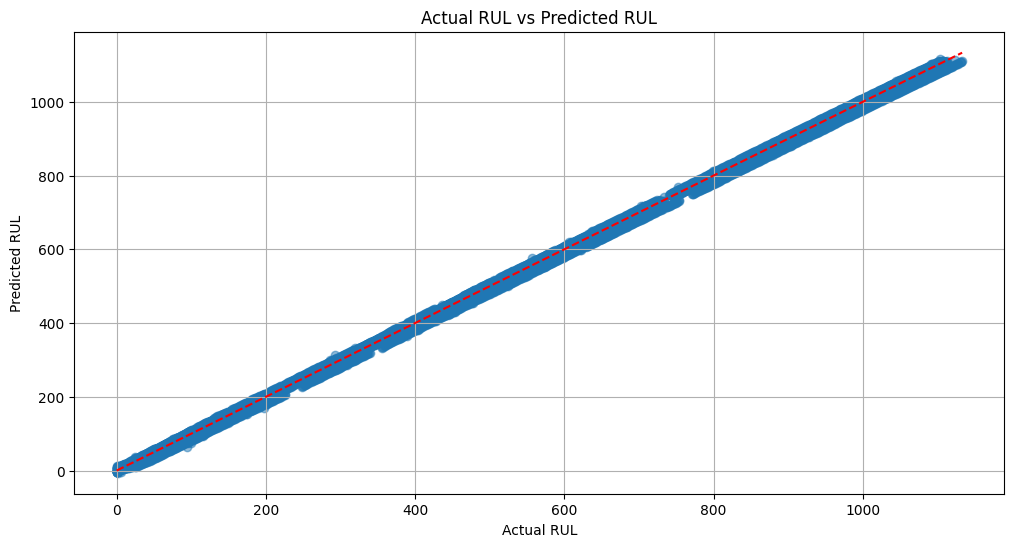

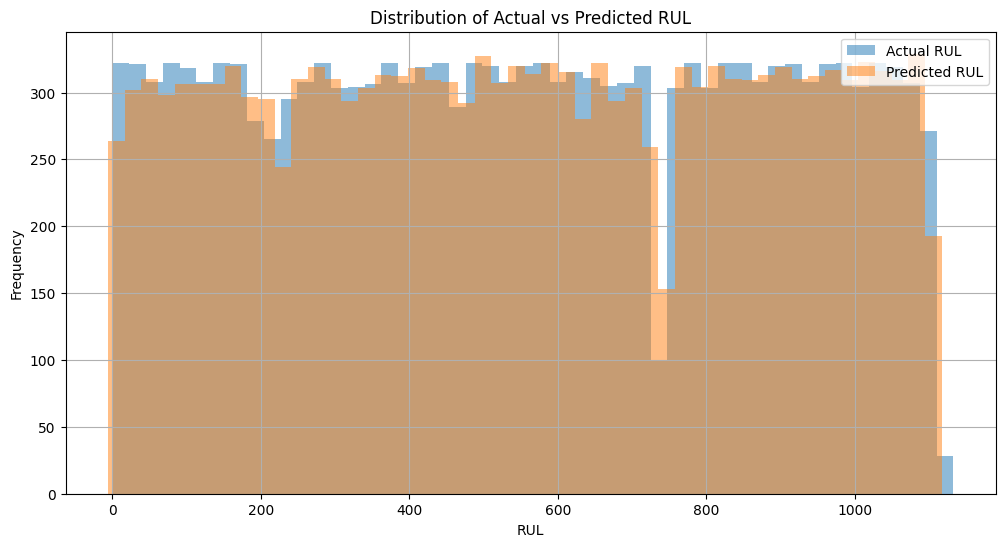

    Actual RUL  Predicted RUL
0         1112    1108.890137
1         1111    1108.197510
2         1110    1107.205322
3         1109    1106.274902
4         1107    1102.364258
5         1106    1109.867798
6         1105    1095.438354
7         1104    1094.880615
8         1103    1093.968140
9         1102    1104.020508
10        1101    1098.896729
11        1100    1097.269409
12        1099    1096.689697
13        1098    1095.412598
14        1097    1093.745728
15        1096    1096.548096
16        1095    1092.940063
17        1094    1092.013916
18        1093    1091.076660
19        1092    1090.139893


In [71]:
# Step 6: Predictions and Visualization
# Make predictions
y_pred = model.predict(X_rfe)

# Plotting Actual RUL vs Predicted RUL
plt.figure(figsize=(12, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--')  # Perfect prediction line
plt.title('Actual RUL vs Predicted RUL')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.grid()
plt.show()

# Plotting distribution of Actual vs Predicted RUL
plt.figure(figsize=(12, 6))
plt.hist(y, bins=50, alpha=0.5, label='Actual RUL')
plt.hist(y_pred, bins=50, alpha=0.5, label='Predicted RUL')
plt.title('Distribution of Actual vs Predicted RUL')
plt.xlabel('RUL')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

# Display predictions
predictions_df = pd.DataFrame({'Actual RUL': y, 'Predicted RUL': y_pred.flatten()})
print(predictions_df.head(20))  # Display first 20 predictions

#Actual RUL and Predicted RUL for each battery

In [72]:
import pandas as pd

# Assuming y and y_pred are your actual and predicted RUL values
predictions_df = pd.DataFrame({'Actual RUL': y, 'Predicted RUL': y_pred.flatten()})

# Save to CSV file
predictions_df.to_csv('RUL_predictions.csv', index=False)

# Print the DataFrame (optional)
print(predictions_df)

       Actual RUL  Predicted RUL
0            1112    1108.890137
1            1111    1108.197510
2            1110    1107.205322
3            1109    1106.274902
4            1107    1102.364258
...           ...            ...
15059           4       6.712042
15060           3       6.163689
15061           2       5.873535
15062           1       4.758291
15063           0      -2.883555

[15064 rows x 2 columns]


#Converting the actual RUL float into int

In [73]:
predictions_df['Actual RUL'] = predictions_df['Actual RUL'].astype(int)
predictions_df['Predicted RUL'] = predictions_df['Predicted RUL'].astype(int)

#Saving the file Actual and Predicted RUL

In [58]:
predictions_df.to_csv('RUL_predictions_int.csv', index=False)